In [7]:
import re
import pandas as pd
import sys
sys.path.append('/home/zxhuang/ugi/covalent_molecule_library')
from tqdm.auto import tqdm


In [3]:
from functional_group_utils import StrictCovalentWarHeadCounter, RelaxedCovalentWarHeadCounter
from rxn_utils import ugi_click_rxn

## deal with azide

In [12]:
with open('azide.smi', 'r') as f:
    lines = f.readlines()
cnt = 0
for l in lines:
    if not re.findall(r'N\=\[N\+\]\=\[N-\]|\[N-\]\=\[N\+\]\=N', l.split()[0]):
        cnt += 1
        print(l.split()[0])
print(cnt)

C[C@H]([NH+]=[N+]=[N-])C1=CC=C(C2=CC=CC=C2)C=C1
CC(C)(C)[PH+](CC[NH+]=[N+]=[N-])C(C)(C)C
2


In [11]:
pattern = r'N\=\[N\+\]\=\[N-\]|\[N-\]\=\[N\+\]\=N'

# 测试字符串
test_string1 = 'N=[N+]=[N-]'
test_string2 = '[N-]=[N+]=N'

# 匹配
match1 = re.match(pattern, test_string1)
match2 = re.match(pattern, test_string2)

# 输出结果
print('Match 1:', match1 is not None)  # True
print('Match 2:', match2 is not None)  # True


Match 1: False
Match 2: True


## clean covalent warhead

In [3]:
strict_covalent_warhead_counter = StrictCovalentWarHeadCounter()
relaxed_covalent_warhead_counter = RelaxedCovalentWarHeadCounter()

In [13]:
# df = pd.read_csv('amine.smi', sep=' ', header=None)
# df = pd.read_csv('acid.smi', sep=' ', header=None)
# df = pd.read_csv('aldehyde.smi', sep=' ', header=None)
df = pd.read_csv('azide.smi', sep=' ', header=None)
df.columns = ['smiles', 'id']
for warhead in relaxed_covalent_warhead_counter.fg_dict:
    if warhead == 'aldehyde':
        continue
    df[warhead] = df['smiles'].apply(lambda x: relaxed_covalent_warhead_counter.count_fg(x, warhead))

In [14]:
df['warhead_cnt'] = df.iloc[:, 2:].sum(axis=1)
df

smiles                  id  \
0                                       [N-]=[N+]=NCCCO     bide-click-am-1   
1                                  CCOC(=O)CN=[N+]=[N-]     bide-click-am-2   
2                                         CCN=[N+]=[N-]     bide-click-am-3   
3                                       [N-]=[N+]=NCCBr     bide-click-am-4   
4                                   COC(=O)CN=[N+]=[N-]     bide-click-am-5   
...                                                 ...                 ...   
2656           CC(C)(C)OC(=O)N1C2CCCC1C(N=[N+]=[N-])CC2  bide-click-am-2682   
2657                      [N-]=[N+]=NC[C@]12COC[C@H]1C2  bide-click-am-2683   
2658               [N-]=[N+]=N[C@H]1C[C@@H](C(F)(F)F)C1  bide-click-am-2684   
2659           [N-]=[N+]=NCC1(C2=CC(C(F)(F)F)=CC=C2)CC1  bide-click-am-2685   
2660  [N-]=[N+]=N[C@H]1C[C@@H]1C1=CC=C(C2=CC(O)=CC=C...  bide-click-am-2686   

      acryloyl  cyano  fluorosulfonyl  alpha_cl_oxo  vinyl_sulfone  propynoyl  \
0            0      0               0             0              0          0   
1            0      0               0             0              0          0   
2            0      0               0             0              0          0   
3            0      0               0             0              0          0   
4            0      0               0             0              0          0   
...        ...    ...             ...           ...            ...        ...   
2656         0      0               0             0              0          0   
2657         0      0               0             0              0          0   
2658         0      0               0             0              0          0   
2659         0      0               0             0              0          0   
2660         0      0               0             0              0          0   

      allenamide  isocyanate  strained_cyclobutane  expoxide_aziridine  NASA  \
0              0           0                     0                   0     0   
1              0           0                     0                   0     0   
2              0           0                     0                   0     0   
3              0           0                     0                   0     0   
4              0           0                     0                   0     0   
...          ...         ...                   ...                 ...   ...   
2656           0           0                     0                   0     0   
2657           0           0                     0                   0     0   
2658           0           0                     0                   0     0   
2659           0           0                     0                   0     0   
2660           0           0                     0                   0     0   

      boronic_acids  SnAr  warhead_cnt  
0                 0     0            0  
1                 0     0            0  
2                 0     0            0  
3                 0     0            0  
4                 0     0            0  
...             ...   ...          ...  
2656              0     0            0  
2657              0     0            0  
2658              0     0            0  
2659              0     0            0  
2660              0     0            0  

[2661 rows x 16 columns]

In [15]:
df_ = df[df['warhead_cnt'] == 0]
df_ = df_[['smiles', 'id']]
# df_.to_csv('amine_no_warhead.smi', sep=' ', index=False, header=False)
# df_.to_csv('acid_no_warhead.smi', sep=' ', index=False, header=False)
# df_.to_csv('aldehyde_no_warhead.smi', sep=' ', index=False, header=False)
df_.to_csv('azide_no_warhead.smi', sep=' ', index=False, header=False)
df_.shape

(2525, 2)

## draw chemical space

In [53]:
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt

from molfeat.trans.fp import FPVecTransformer
from molfeat.calc.pharmacophore import Pharmacophore2D
from molfeat.trans.base import MoleculeTransformer

ecfp_transformer = FPVecTransformer(kind='ecfp-count', dtype=float, n_jobs=8, length=1024)
pmapper_transformer = MoleculeTransformer(featurizer=Pharmacophore2D(factory='pmapper'), dtype=float, n_jobs=8)


In [60]:
# random synthesis 3,000 ugi-click molecules with ace-on-(amine, acid, aldehyde)
df_ace_on_amine = pd.read_csv('../BBs_with_ace/ace_on_amine.smi', sep=' ', header=None)
df_ace_on_amine.columns = ['smiles', 'id']
df_ace_on_acid = pd.read_csv('../BBs_with_ace/ace_on_acid.smi', sep=' ', header=None)
df_ace_on_acid.columns = ['smiles', 'id']
df_ace_on_aldehyde = pd.read_csv('../BBs_with_ace/ace_on_aldehyde.smi', sep=' ', header=None)
df_ace_on_aldehyde.columns = ['smiles', 'id']

df_acid = pd.read_csv('acid_no_warhead.smi', sep=' ', header=None)
df_acid.columns = ['smiles', 'id']
df_amine = pd.read_csv('amine_no_warhead.smi', sep=' ', header=None)
df_amine.columns = ['smiles', 'id']
df_aldehyde = pd.read_csv('aldehyde_no_warhead.smi', sep=' ', header=None)
df_aldehyde.columns = ['smiles', 'id']
df_nc = pd.read_csv('NC.smi', sep=' ', header=None)
df_nc.columns = ['smiles', 'id']
df_azide = pd.read_csv('azide_no_warhead.smi', sep=' ', header=None)
df_azide.columns = ['smiles', 'id']

In [102]:
sample_num = 1000
df_ugi_click_sample = pd.DataFrame(columns=['id', 'smiles', 'source'])
for i in tqdm(range(sample_num), desc='ace_on_amine'):
    ace_on_amine_id, ace_on_amine_smiles = df_ace_on_amine.sample(1)['id'].values[0], df_ace_on_amine.sample(1)['smiles'].values[0]
    acid_id, acid_smiles = df_acid.sample(1)['id'].values[0], df_acid.sample(1)['smiles'].values[0]
    aldehyde_id, aldehyde_smiles = df_aldehyde.sample(1)['id'].values[0], df_aldehyde.sample(1)['smiles'].values[0]
    nc_id, nc_smiles = df_nc.sample(1)['id'].values[0], df_nc.sample(1)['smiles'].values[0]
    azide_id, azide_smiles = df_azide.sample(1)['id'].values[0], df_azide.sample(1)['smiles'].values[0]
    prod_smiles = ugi_click_rxn(
        acid_smi = acid_smiles,
        aldehyde_smi = aldehyde_smiles,
        nc_smi = nc_smiles,
        amine_smi = ace_on_amine_smiles,
        azide_smi = azide_smiles
    )
    prod_id = f'{acid_id}_{aldehyde_id}_{nc_id}_{ace_on_amine_id}_{azide_id}'
    df_ugi_click_sample = pd.concat([df_ugi_click_sample, pd.DataFrame({'id': [prod_id], 'smiles': [prod_smiles], 'source': ['ace_on_amine']})], ignore_index=True)

for i in tqdm(range(sample_num), desc='ace_on_acid'):
    ace_on_acid_id, ace_on_acid_smiles = df_ace_on_acid.sample(1)['id'].values[0], df_ace_on_acid.sample(1)['smiles'].values[0]
    amine_id, amine_smiles = df_amine.sample(1)['id'].values[0], df_amine.sample(1)['smiles'].values[0]
    aldehyde_id, aldehyde_smiles = df_aldehyde.sample(1)['id'].values[0], df_aldehyde.sample(1)['smiles'].values[0]
    nc_id, nc_smiles = df_nc.sample(1)['id'].values[0], df_nc.sample(1)['smiles'].values[0]
    azide_id, azide_smiles = df_azide.sample(1)['id'].values[0], df_azide.sample(1)['smiles'].values[0]
    prod_smiles = ugi_click_rxn(
        acid_smi = ace_on_acid_smiles,
        aldehyde_smi = aldehyde_smiles,
        nc_smi = nc_smiles,
        amine_smi = amine_smiles,
        azide_smi = azide_smiles
    )
    prod_id = f'{ace_on_acid_id}_{aldehyde_id}_{nc_id}_{amine_id}_{azide_id}'
    df_ugi_click_sample = pd.concat([df_ugi_click_sample, pd.DataFrame({'id': [prod_id], 'smiles': [prod_smiles], 'source': ['ace_on_acid']})], ignore_index=True)

for i in tqdm(range(sample_num), desc='ace_on_aldehyde'):
    ace_on_aldehyde_id, ace_on_aldehyde_smiles = df_ace_on_aldehyde.sample(1)['id'].values[0], df_ace_on_aldehyde.sample(1)['smiles'].values[0]
    amine_id, amine_smiles = df_amine.sample(1)['id'].values[0], df_amine.sample(1)['smiles'].values[0]
    acid_id, acid_smiles = df_acid.sample(1)['id'].values[0], df_acid.sample(1)['smiles'].values[0]
    nc_id, nc_smiles = df_nc.sample(1)['id'].values[0], df_nc.sample(1)['smiles'].values[0]
    azide_id, azide_smiles = df_azide.sample(1)['id'].values[0], df_azide.sample(1)['smiles'].values[0]
    prod_smiles = ugi_click_rxn(
        acid_smi = acid_smiles,
        aldehyde_smi = ace_on_aldehyde_smiles,
        nc_smi = nc_smiles,
        amine_smi = amine_smiles,
        azide_smi = azide_smiles
    )
    prod_id = f'{acid_id}_{ace_on_aldehyde_id}_{nc_id}_{amine_id}_{azide_id}'
    df_ugi_click_sample = pd.concat([df_ugi_click_sample, pd.DataFrame({'id': [prod_id], 'smiles': [prod_smiles], 'source': ['ace_on_aldehyde']})], ignore_index=True)

df_ugi_click_sample


ace_on_amine:   0%|          | 0/1000 [00:00<?, ?it/s]

ace_on_acid:   0%|          | 0/1000 [00:00<?, ?it/s]

ace_on_aldehyde:   0%|          | 0/1000 [00:00<?, ?it/s]

id  \
0     bide-uc-462_bide-uc-1634_bide-uc-1858_bide-uc-...   
1     bide-uc-2148_bide-uc-1114_bide-uc-1858_bide-uc...   
2     bide-uc-3903_bide-uc-4352_bide-uc-1140_bide-uc...   
3     bide-uc-4746_bide-uc-4906_bide-uc-1858_bide-uc...   
4     bide-uc-2185_bide-uc-1619_bide-uc-1140_bide-uc...   
...                                                 ...   
2995  bide-uc-2123_bide-uc-1890_bide-uc-1140_bide-uc...   
2996  bide-uc-177_bide-uc-1659_bide-uc-1140_bide-uc-...   
2997  bide-uc-3752_bide-uc-1659_bide-uc-1140_bide-uc...   
2998  bide-uc-1155_bide-uc-1659_bide-uc-1858_bide-uc...   
2999  bide-uc-3620_bide-uc-1890_bide-uc-1858_bide-uc...   

                                                 smiles           source  
0     CC(C)(C)NC(=O)C(C1=C(C(C)(C)C)NC=N1)N(CC1=CN([...     ace_on_amine  
1     CC1=C(O)C(C(C(=O)NCC2=CC=CC=C2)N(C(=O)C2=CC(Cl...     ace_on_amine  
2     CCC(C)(C)C1CCC(N2C=C(C3=CC(N(C(=O)C4=C(F)C=CC=...     ace_on_amine  
3     CN(C)CC(C(=O)NCC1=CC=CC=C1)N(C(=O)CC1=CC=C2C=C...     ace_on_amine  
4     CC(C)C1=CC=CC=C1C(C(=O)NC(C)(C)C)N(C(=O)C1CCC2...     ace_on_amine  
...                                                 ...              ...  
2995  COC1=NC=C(F)C(C(=O)N(C2=CC(Cl)=C(F)C=C2F)C(C(=...  ace_on_aldehyde  
2996  C=C[C@@H](CO)N1C=C(C2=CC=C(C(C(=O)NC(C)(C)C)N(...  ace_on_aldehyde  
2997  COC1=C(F)C=C(CN2C=C(C3=CC=CC=C3C(C(=O)NCC3=CC=...  ace_on_aldehyde  
2998  CC1=C(CN2C=C(C3=CC=C(C(C(=O)NC(C)(C)C)N(CC4(O)...  ace_on_aldehyde  
2999  CCOC(=O)C1(CN2C=C(C3=CC=C(C(C(=O)NC(C)(C)C)N(C...  ace_on_aldehyde  

[3000 rows x 3 columns]

In [103]:
enamine_data_path = '/home/zxhuang/modular_click/virtual_reagents/Enamine/previous/Enamine_2022_sampled_data.csv'
df_enamine = pd.read_csv(enamine_data_path)
df_enamine['source'] = 'Enamine-REAL'
df_enamine.rename(columns={'idnumber': 'id'}, inplace=True)
df_enamine

smiles           id  \
0       COC1=CC(F)=C(C(=O)NC(C)(C)CCCNC(=O)OC(C)(C)C)C...  Z3085457096   
1       CC(C)CN1CCC(C(=O)N2CCN(C3=CC(C(F)(F)F)=NC=N3)C...  Z4424227820   
2       COC1=CC=C2C=CC=C(CC(=O)N=S3(=O)CCCC4(C3)OCCO4)...  Z3640991685   
3         O=C(CN1CCN(C(=O)C2=CC=NN2CC(F)(F)F)CC1)N1CCCCC1  Z2254355142   
4       CCOC(=O)C1=CC2=CC=CC(C(=O)N(CC3CCOCC3)C3CC3)=C2N1  Z5249274034   
...                                                   ...          ...   
110135          O=C(CC1(O)CCCCC1)NC1=CC=CC=C1CC1=CC=CC=C1  Z1203506945   
110136          CC1(C)CC(CO)CN(C(=O)C2CCC(OCC3CCC3)CC2)C1  Z4027139019   
110137    O=C(NC1=CC=C(OCC2=CC=CC=N2)C(F)=C1)C1=CN=C(S)N1  Z1739016667   
110138    CC(=O)C1=CC=C(NC(=O)C(=O)NC2CCC(=O)NC2(C)C)C=C1  Z2023411353   
110139         CCOC1=NC=CC=C1C(=O)NCC(=O)N1CC2=CC=CC=C2C1  Z1953801387   

              source  
0       Enamine-REAL  
1       Enamine-REAL  
2       Enamine-REAL  
3       Enamine-REAL  
4       Enamine-REAL  
...              ...  
110135  Enamine-REAL  
110136  Enamine-REAL  
110137  Enamine-REAL  
110138  Enamine-REAL  
110139  Enamine-REAL  

[110140 rows x 3 columns]

In [104]:
chemdiv_data_path = '/home/zxhuang/modular_click/virtual_reagents/chemdiv/csv/chemdiv_total.csv'
df_chemdiv = pd.read_csv(chemdiv_data_path)
df_chemdiv['source'] = 'Chemdiv'
df_chemdiv

id                                    smiles   source
0        K780-0323      CC(=O)Nc1cc(C(=O)O)ccc1Sc1ccc(C)cc1C  Chemdiv
1        K780-0325                      COc1cc(Br)cc(C=O)c1O  Chemdiv
2        K780-0331      Cc1cc(Cl)n2nc(C)c(-c3ccc(Cl)cc3)c2n1  Chemdiv
3        K780-0360               Cc1cccc(-c2nc(CCl)c(C)o2)c1  Chemdiv
4        K780-0366        CCCC(=O)Nc1cc(C(=O)O)ccc1Sc1ccccc1  Chemdiv
...            ...                                       ...      ...
1661833  K780-0312  COC(=O)c1ccc(Sc2ccccc2)c([N+](=O)[O-])c1  Chemdiv
1661834  K780-0317              CC(=O)Oc1ccc2c(C)cc(=O)oc2c1  Chemdiv
1661835  K780-0318                    Cc1nc(N)[nH]c(=O)c1CCO  Chemdiv
1661836  K780-0319            CCOC(=O)/C(Cl)=C(/C)Nc1ccccc1N  Chemdiv
1661837  K780-0320   Cc1cc(=O)n2nc(C)c(-c3ccc(Cl)cc3)c2[nH]1  Chemdiv

[1661838 rows x 3 columns]

In [105]:
click_data_path = '/home/zxhuang/modular_click/virtual_reagents/triazole_sele.csv'
df_click = pd.read_csv(click_data_path)
df_click['source'] = 'click'
df_click.rename(columns={'mol_id': 'id', 'triazole_smi': 'smiles'}, inplace=True)
df_click = df_click[['id', 'smiles', 'source']]
df_click

id                                             smiles source
0             n1-a2   COC(=O)C(Cc1cn(CC(=O)N2CCCC2)nn1)NC(=O)OC(C)(C)C  click
1             n1-a4                CC(C)CC(C)(O)c1cn(CC(=O)N2CCCC2)nn1  click
2             n1-a5             CC(C)=CCCC(C)(O)c1cn(CC(=O)N2CCCC2)nn1  click
3            n1-a21                O=C(Cn1cc(-c2ccc(CO)cc2)nn1)N1CCCC1  click
4            n1-a22                 O=C(Cn1cc(-c2ccc(O)cc2)nn1)N1CCCC1  click
...             ...                                                ...    ...
1915582  n6366-a605         CC(=O)NCc1cn(C2(c3ccc(C(F)(F)F)cc3)CC2)nn1  click
1915583  n6366-a608  Nc1ccc(-c2cn(C3(c4ccc(C(F)(F)F)cc4)CC3)nn2)c(C...  click
1915584  n6366-a613     Nc1cnc(-c2cn(C3(c4ccc(C(F)(F)F)cc4)CC3)nn2)cn1  click
1915585  n6366-a615  Oc1ccc(-c2ccc(-c3cn(C4(c5ccc(C(F)(F)F)cc5)CC4)...  click
1915586  n6366-a619            CC(N)c1cn(C2(c3ccc(C(F)(F)F)cc3)CC2)nn1  click

[1915587 rows x 3 columns]

In [106]:
df_enamine_sampled = df_enamine.sample(sample_num*3)
df_chemdiv_sampled = df_chemdiv.sample(sample_num*3)
df_click_sampled = df_click.sample(sample_num*3)
df_merged = pd.concat([
    df_enamine_sampled, 
    df_chemdiv_sampled, 
    df_click_sampled, 
    df_ugi_click_sample
    ], ignore_index=True)
df_merged

smiles  \
0      COC1=CC2=CC=CC=C2C=C1C(=O)NC1(C(=O)OC(C)(C)C)C...   
1         COC1=CC=C(CN2CCCN(CC3=CC=CC=C3C3CC3)CC2=O)C=C1   
2      NCC1=CN2C=CC(C(=O)N3CCC(C(=O)NCC4=CC=CC=C4)C3)...   
3             CC1C2=NN=CN2CCN1C(=O)C1(C2=CC=CC=C2F)CCCC1   
4                   O=C(C1=CC=C2CCCC2=N1)N1CCC(OCCCO)CC1   
...                                                  ...   
11995  COC1=NC=C(F)C(C(=O)N(C2=CC(Cl)=C(F)C=C2F)C(C(=...   
11996  C=C[C@@H](CO)N1C=C(C2=CC=C(C(C(=O)NC(C)(C)C)N(...   
11997  COC1=C(F)C=C(CN2C=C(C3=CC=CC=C3C(C(=O)NCC3=CC=...   
11998  CC1=C(CN2C=C(C3=CC=C(C(C(=O)NC(C)(C)C)N(CC4(O)...   
11999  CCOC(=O)C1(CN2C=C(C3=CC=C(C(C(=O)NC(C)(C)C)N(C...   

                                                      id           source  
0                                            Z2676457938     Enamine-REAL  
1                                            Z1703657706     Enamine-REAL  
2                                            Z6382380871     Enamine-REAL  
3                                            Z1848852990     Enamine-REAL  
4                                            Z3192530677     Enamine-REAL  
...                                                  ...              ...  
11995  bide-uc-2123_bide-uc-1890_bide-uc-1140_bide-uc...  ace_on_aldehyde  
11996  bide-uc-177_bide-uc-1659_bide-uc-1140_bide-uc-...  ace_on_aldehyde  
11997  bide-uc-3752_bide-uc-1659_bide-uc-1140_bide-uc...  ace_on_aldehyde  
11998  bide-uc-1155_bide-uc-1659_bide-uc-1858_bide-uc...  ace_on_aldehyde  
11999  bide-uc-3620_bide-uc-1890_bide-uc-1858_bide-uc...  ace_on_aldehyde  

[12000 rows x 3 columns]

In [107]:
umap_transformer = umap.UMAP(n_components=2)
pca_transformer = PCA(n_components=2)
tsne_transformer = TSNE(n_components=2)

X_ecfp = ecfp_transformer(df_merged['smiles'])
print('ECFP done')
X_pca = pca_transformer.fit_transform(X_ecfp)
df_merged['ECFP4_PCA_1'] = X_pca[:, 0]
df_merged['ECFP4_PCA_2'] = X_pca[:, 1]
print('PCA done')
X_tsne = tsne_transformer.fit_transform(X_ecfp)
df_merged['ECFP4_TSNE_1'] = X_tsne[:, 0]
df_merged['ECFP4_TSNE_2'] = X_tsne[:, 1]
print('TSNE done')
X_umap = umap_transformer.fit_transform(X_ecfp)
df_merged['ECFP4_UMAP_1'] = X_umap[:, 0]
df_merged['ECFP4_UMAP_2'] = X_umap[:, 1]
print('UMAP done')

ECFP done
PCA done
TSNE done
UMAP done


<Axes: xlabel='ECFP4_UMAP_1', ylabel='ECFP4_UMAP_2'>

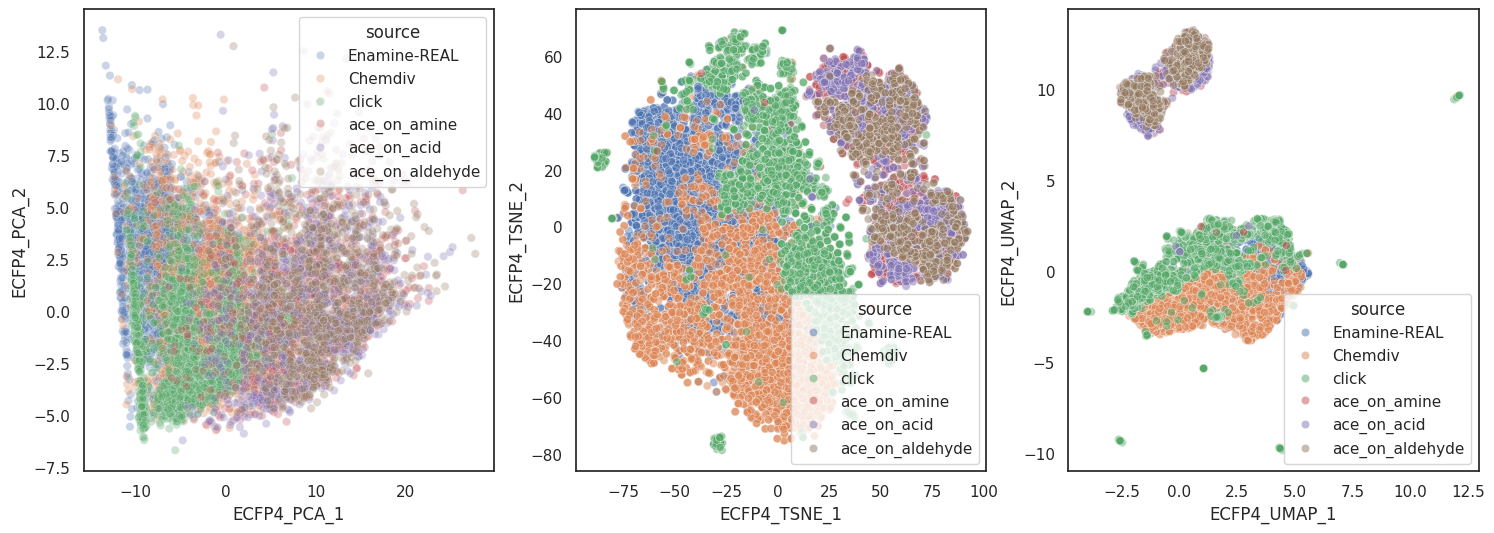

In [129]:
# ecfp 6000 samples
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=df_merged, x='ECFP4_PCA_1', y='ECFP4_PCA_2', hue='source', ax=axes[0], alpha=0.3)
sns.scatterplot(data=df_merged, x='ECFP4_TSNE_1', y='ECFP4_TSNE_2', hue='source', ax=axes[1], alpha=0.5)
sns.scatterplot(data=df_merged, x='ECFP4_UMAP_1', y='ECFP4_UMAP_2', hue='source', ax=axes[2], alpha=0.5)


<Axes: xlabel='ECFP4_TSNE_1', ylabel='ECFP4_TSNE_2'>

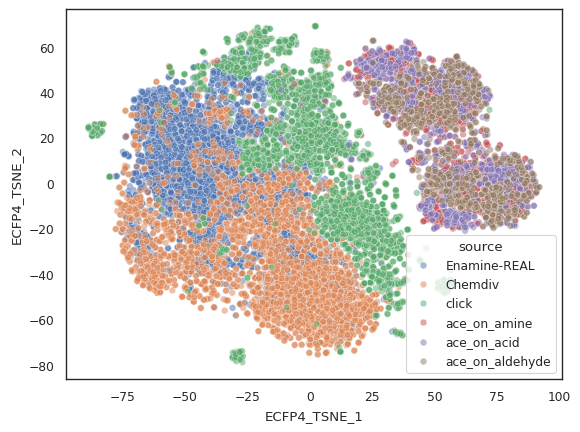

In [126]:
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1)
sns.scatterplot(data=df_merged, x='ECFP4_TSNE_1', y='ECFP4_TSNE_2', hue='source', alpha=0.5)


In [109]:
df_ = df_merged[(df_merged['source'] == 'ace_on_amine') & (df_merged['ECFP4_UMAP_1'] < 5)]
df_['smiles'].tolist()

['CC(C)(C)NC(=O)C(C1=C(C(C)(C)C)NC=N1)N(CC1=CN([C@@H](CO)C2=NC=CS2)N=N1)C(=O)[C@@H]1C[C@@H](F)CN1',
 'CC1=C(O)C(C(C(=O)NCC2=CC=CC=C2)N(C(=O)C2=CC(Cl)=CC(F)=C2Cl)C2=CC=CC(C3=CN([C@H]4CCN(C(=O)OC(C)(C)C)C[C@H]4F)N=N3)=C2)=CC=C1',
 'CCC(C)(C)C1CCC(N2C=C(C3=CC(N(C(=O)C4=C(F)C=CC=C4Br)C(C(=O)NCC4=CC=CC=C4)C4=C5C=CC=CN5C=N4)=CC=C3)N=N2)CC1',
 'CN(C)CC(C(=O)NCC1=CC=CC=C1)N(C(=O)CC1=CC=C2C=CNC2=C1)C1=CC=CC(C2=CN(CC3CNC3)N=N2)=C1',
 'CC(C)C1=CC=CC=C1C(C(=O)NC(C)(C)C)N(C(=O)C1CCC2=C(C=CC=C2)O1)C1=CC=CC(C2=CN(CC3CN(CC4=CC=CC=C4)CCO3)N=N2)=C1',
 'CCC1=CC(C(C(=O)NC(C)(C)C)N(C(=O)C2=CC=CC3=CN(C)N=C23)C2=CC=CC=C2C2=CN(C[C@H]3CCC(=O)N3)N=N2)=CC=C1',
 'CC(=O)N1CCC[C@@H]1C(=O)N(C1=CC=CC(C2=CN(CC3=CCN(CC4=CC=CC=C4)CC3)N=N2)=C1)C(C(=O)NCC1=CC=CC=C1)C1=CN=C(C2=CC=CC=C2F)N=C1',
 'CC1=C(OCCN2C=C(C3=CC=CC=C3N(C(=O)C3=CC4=CC=C(Cl)C=C4N3)C(C(=O)NC(C)(C)C)C3=CC(Br)=CC(F)=C3F)N=N2)C=CC=C1',
 'CC1=NN(C)C(C)=C1C(C(=O)NCC1=CC=CC=C1)N(C(=O)C1=CC(Br)=CC2=C1NC=C2)C1=CC=CC=C1C1=CN(C(C2=C(F)C=CC(Br)=C2)C2CC2)N=N1',
 'CN1

In [110]:
X_pmapper = pmapper_transformer(df_merged['smiles'])
print('Pharm done')
X_pca = pca_transformer.fit_transform(X_pmapper)
df_merged['Pharm_PCA_1'] = X_pca[:, 0]
df_merged['Pharm_PCA_2'] = X_pca[:, 1]
print('PCA done')
X_tsne = tsne_transformer.fit_transform(X_pmapper)
df_merged['Pharm_TSNE_1'] = X_tsne[:, 0]
df_merged['Pharm_TSNE_2'] = X_tsne[:, 1]
print('TSNE done')
X_umap = umap_transformer.fit_transform(X_pmapper)
df_merged['Pharm_UMAP_1'] = X_umap[:, 0]
df_merged['Pharm_UMAP_2'] = X_umap[:, 1]
print('UMAP done')

Pharm done
PCA done
TSNE done
UMAP done


<Axes: xlabel='Pharm_TSNE_1', ylabel='Pharm_TSNE_2'>

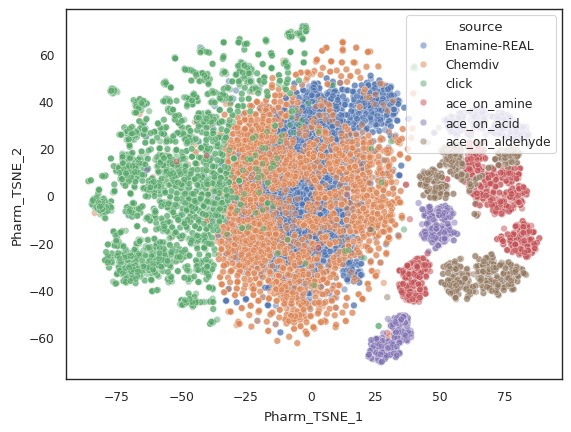

In [124]:
# pharmacophore 6000 samples
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# sns.scatterplot(data=df_merged, x='Pharm_PCA_1', y='Pharm_PCA_2', hue='source', ax=axes[0], alpha=0.5)
# sns.scatterplot(data=df_merged, x='Pharm_TSNE_1', y='Pharm_TSNE_2', hue='source', ax=axes[1], alpha=0.5)
# sns.scatterplot(data=df_merged, x='Pharm_UMAP_1', y='Pharm_UMAP_2', hue='source', ax=axes[2], alpha=0.5)
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1)
sns.scatterplot(data=df_merged, x='Pharm_TSNE_1', y='Pharm_TSNE_2', hue='source', alpha=0.5)


<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

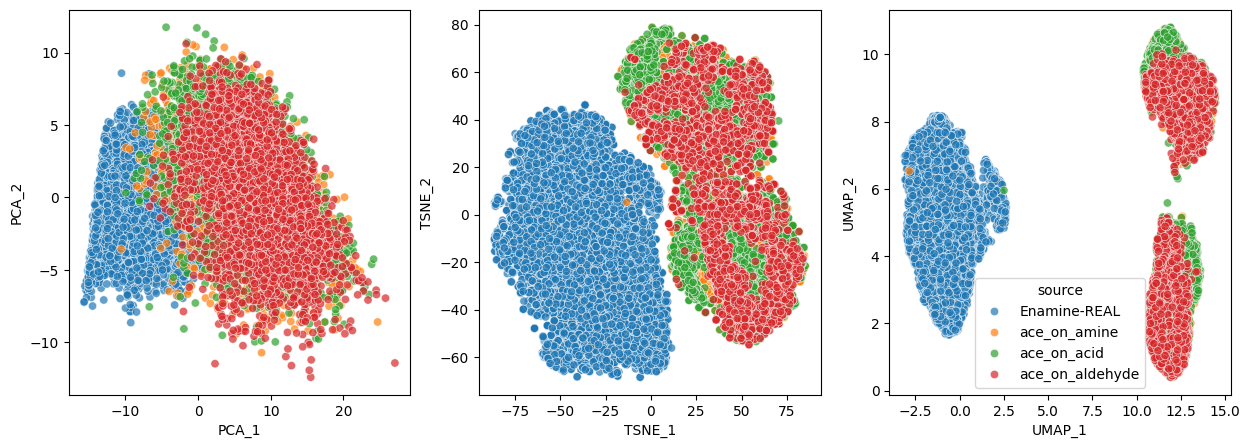

In [28]:
# ecfp 10,000 samples
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=df_merged, x='PCA_1', y='PCA_2', hue='source', ax=ax[0], alpha=0.7, legend=False)
sns.scatterplot(data=df_merged, x='TSNE_1', y='TSNE_2', hue='source', ax=ax[1], alpha=0.7, legend=False)
sns.scatterplot(data=df_merged, x='UMAP_1', y='UMAP_2', hue='source', ax=ax[2], alpha=0.7, )


<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

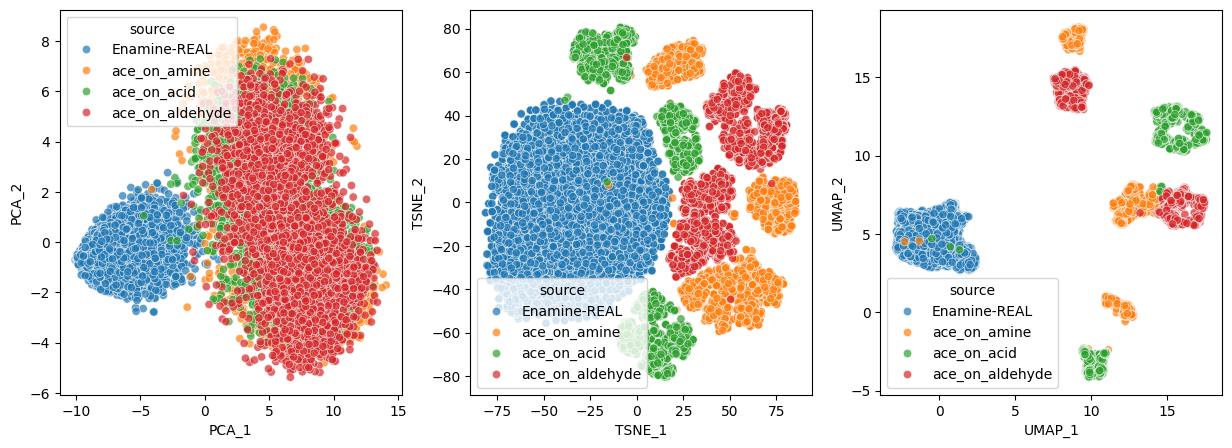

In [30]:
# pmapper 10,000 samples
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=df_merged, x='PCA_1', y='PCA_2', hue='source', ax=ax[0], alpha=0.7, )
sns.scatterplot(data=df_merged, x='TSNE_1', y='TSNE_2', hue='source', ax=ax[1], alpha=0.7, )
sns.scatterplot(data=df_merged, x='UMAP_1', y='UMAP_2', hue='source', ax=ax[2], alpha=0.7, )

<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

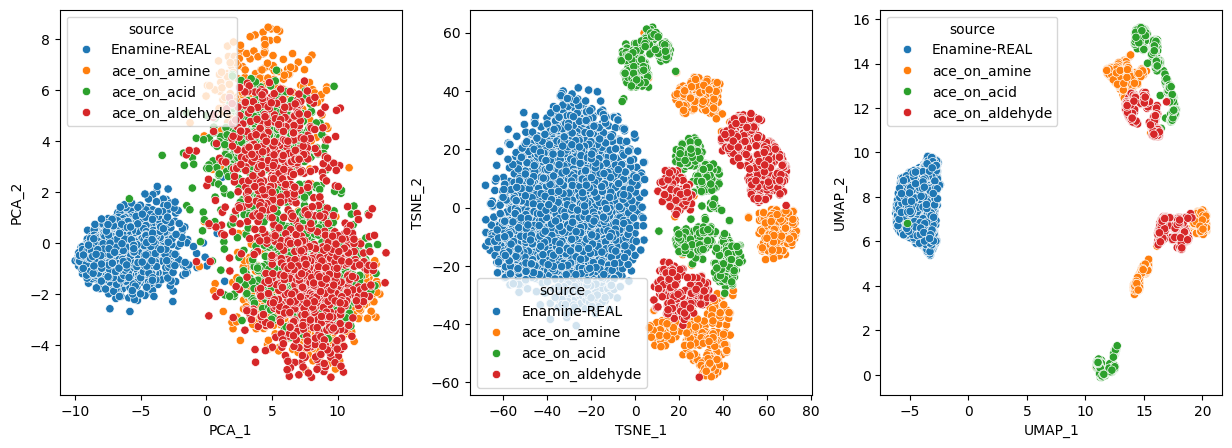

In [22]:
# pmapper 3000 samples
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=df_merged, x='PCA_1', y='PCA_2', hue='source', ax=ax[0])
sns.scatterplot(data=df_merged, x='TSNE_1', y='TSNE_2', hue='source', ax=ax[1])
sns.scatterplot(data=df_merged, x='UMAP_1', y='UMAP_2', hue='source', ax=ax[2])

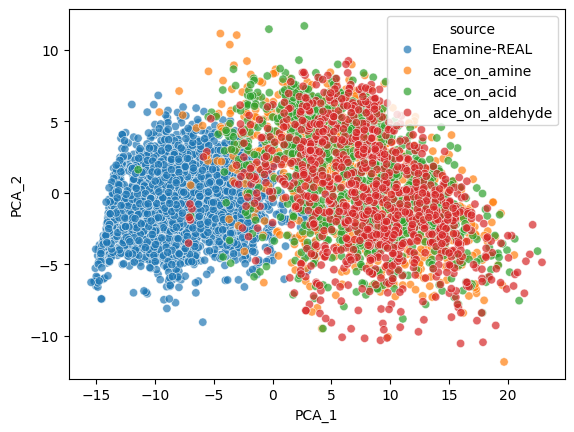

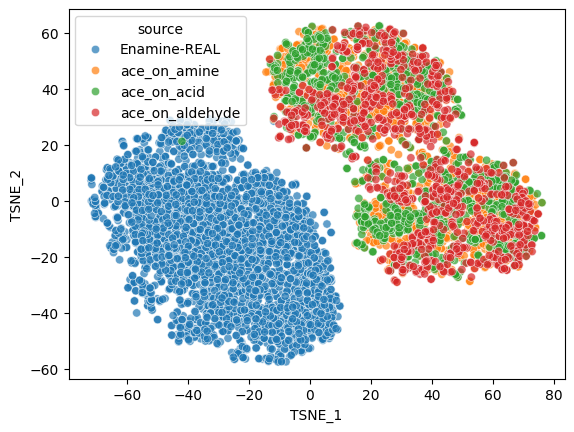

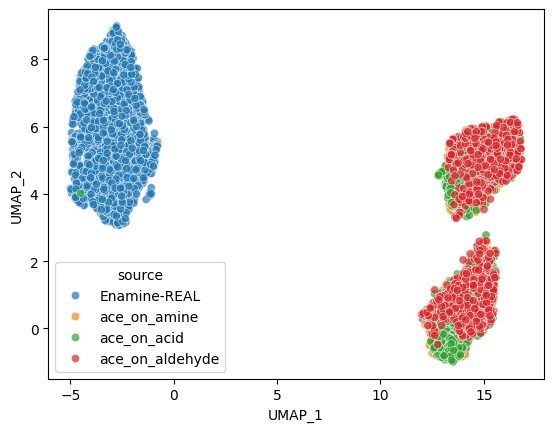

In [19]:
# ecfp 3000 samples
sns.scatterplot(data=df_merged, x='PCA_1', y='PCA_2', hue='source', alpha=0.7)
plt.show()
sns.scatterplot(data=df_merged, x='TSNE_1', y='TSNE_2', hue='source', alpha=0.7)
plt.show()
sns.scatterplot(data=df_merged, x='UMAP_1', y='UMAP_2', hue='source', alpha=0.7)
plt.show()